# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import csv
import cv2
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np
import random
from itertools import groupby
%matplotlib inline
from keras import layers
from keras import models
from keras import utils

Using TensorFlow backend.


In [2]:
training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
all_labels = []
#create array of all labels
with open('signnames.csv', 'r') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        all_labels += [row[1]]
        
all_labels=all_labels[1:]

In [4]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation =len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

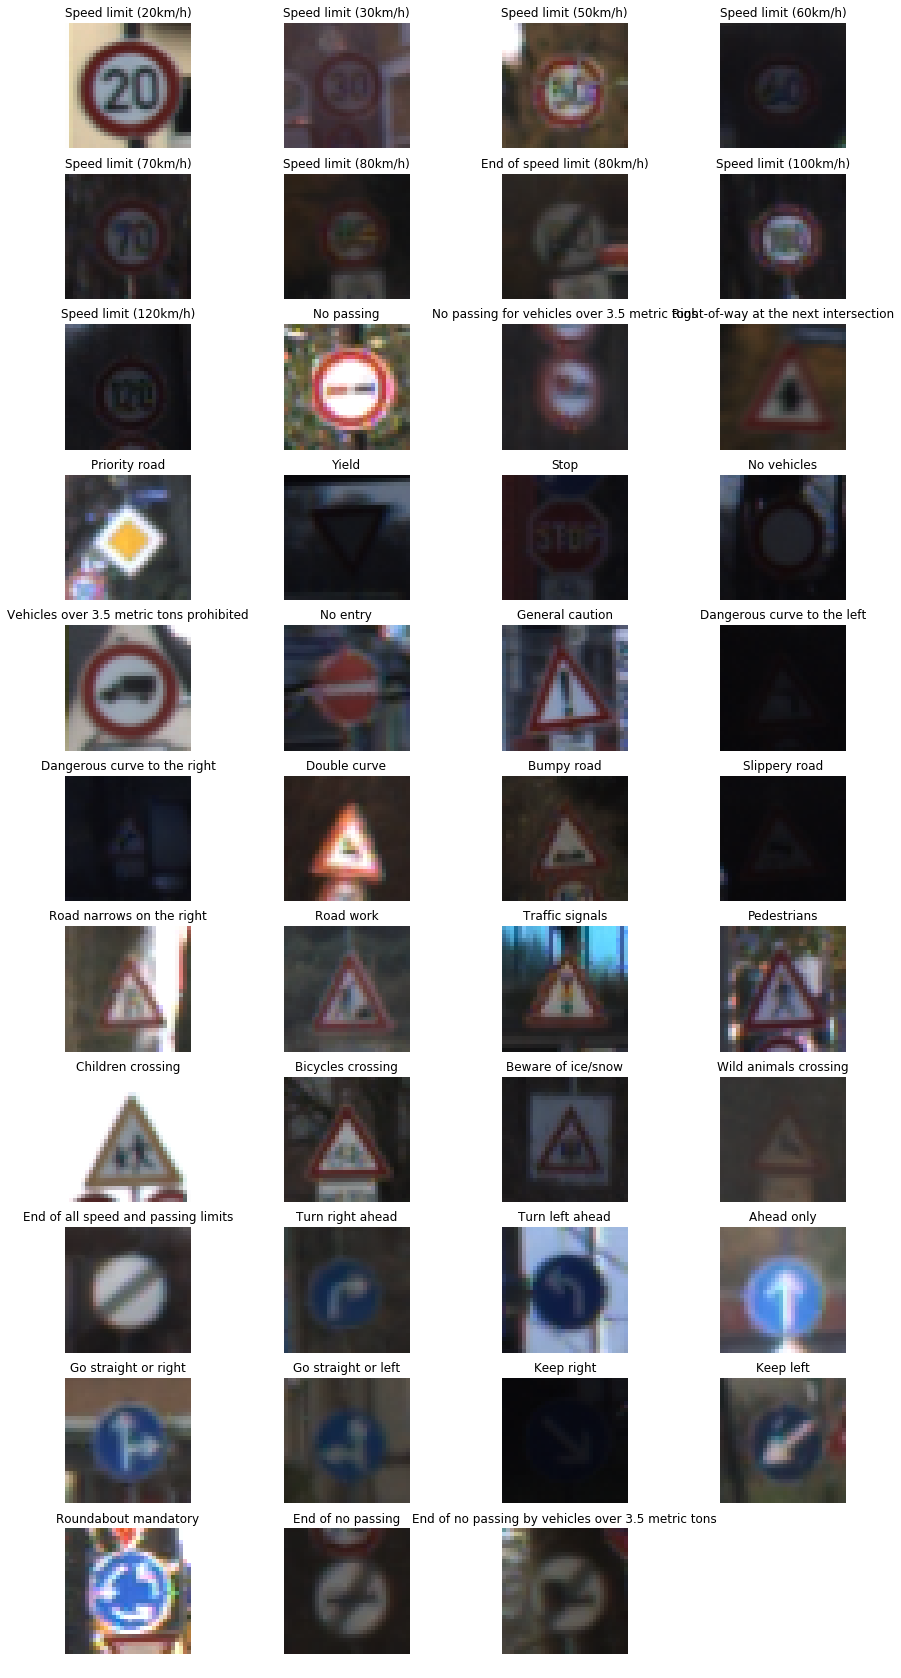

In [5]:
# Show images with it label.
num_of_samples=[]
plt.figure(figsize=(15, 30))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(all_labels[i])
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()
plt.savefig('graphs/origional_trainingset.jpg')

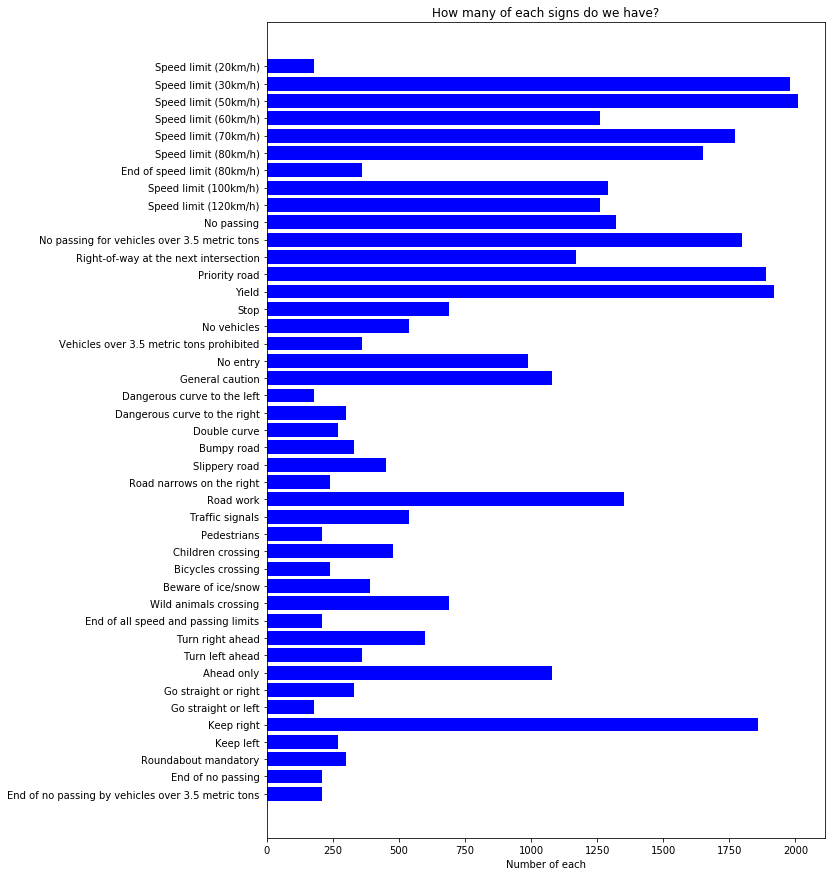

In [6]:
#Show number of images per label
fig, ax = plt.subplots(figsize=(10, 15))

labels = np.arange(len(all_labels))
unique, numOfEach = np.unique(y_train, return_counts=True)
ax.barh(labels, numOfEach, align='center', color='blue')
ax.set_yticks(labels)
ax.set_yticklabels(all_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of each')
ax.set_title('How many of each signs do we have?')

plt.show()
plt.savefig('graphs/origional_trainingset_distribution.jpg')

### Pre-process the Data Set (normalization, grayscale, etc.)

In [7]:
#one hot encode labels
y_train_OHE= utils.to_categorical(y_train, num_classes=43)
y_valid_OHE= utils.to_categorical(y_valid, num_classes=43)
y_test_OHE= utils.to_categorical(y_test, num_classes=43)

We don't need colour image to identify traffic signs so we convert images in the all dataset to grayscale.  

In [8]:
#convert image data to gray scale
X_train_gray=np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gray=np.sum(X_valid/3, axis=3, keepdims=True)
X_test_gray=np.sum(X_test/3, axis=3, keepdims=True)
print('RGB shape:', X_train.shape)
print('Grayscale shape:', X_train_gray.shape)

RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)


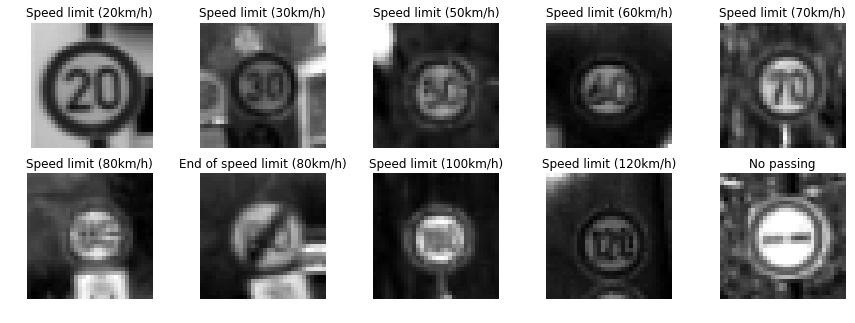

In [9]:
#plt gary scale images to visual
plt.figure(figsize=(15, 30))
for i in range(0, 10):
    plt.subplot(11, 5, i+1)
    x_selected = X_train_gray[y_train == i].squeeze()
    plt.imshow(x_selected[0],  cmap='gray') #draw the first image of each class
    plt.title(all_labels[i])
    plt.axis('off')
plt.show()
plt.savefig('graphs/gray_trainingset.jpg')

In [10]:
print(np.mean(X_train_gray))
print(np.mean(X_valid_gray))
print(np.mean(X_test_gray))

82.677589037
83.5564273756
82.1484603612


Above output shows that we need to normalize images because mean value has to be nearer to zero 

In [11]:
X_train_norm = (X_train_gray - 128)/128 
X_valid_norm= (X_valid_gray - 128)/128 
X_test_norm = (X_test_gray - 128)/128

print(np.mean(X_train_norm))
print(np.mean(X_valid_norm))
print(np.mean(X_test_norm))

-0.354081335648
-0.347215411128
-0.358215153428


Augmenting the training set might help improve model performance. Common data augmentation techniques include rotation, translation, zoom, flips, and/or color perturbation. This Image Augmentation can be done using keras library, where ImageDataGenerator class is used to perform different image Augmentation Operations

In [12]:
#Image Augmentation and Data Generators
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                rotation_range=20, 
                                width_shift_range=0.2, 
                                height_shift_range=0.2, 
                                shear_range=0.2, 
                                zoom_range=0.2, 
#                                 horizontal_flip=True,
                                  )

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_gray, y_train_OHE, batch_size=128, shuffle=True,)

validation_generator = test_datagen.flow(X_valid_gray,y_valid_OHE, batch_size=128, shuffle=True )

test_generator = test_datagen.flow(X_test_gray, y_test_OHE , batch_size=128, shuffle=True)

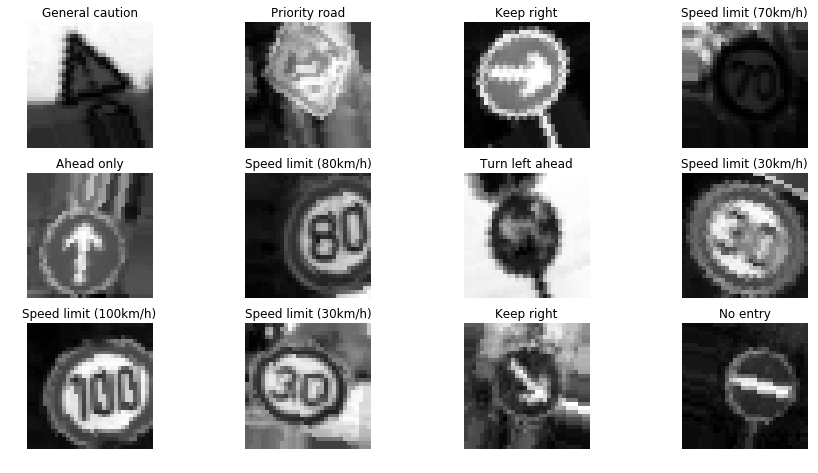

In [13]:
#Visulize images after Preprocessing and data Augmentation
for X_batch, y_batch in train_generator:
    plt.figure(figsize=(15, 30))
    for i in range(0, 12): 
        # i am taking top 12 images from first batch
        plt.subplot(11, 4, i+1)
        plt.imshow(X_batch[i].squeeze(),  cmap='gray') #draw the first image of each class
        
        '''
        we are using one hot encoded label so we need to convert to integer inorder to get origional label
        from all_labels array
        I am doing this binary matrix to integer conversion (reverse of one hot encoding) 
        using "np.where(y_batch[i]==1)[0][0]]" to get integer
        so that we can give proper title to each image
        '''
        plt.title(all_labels[np.where(y_batch[i]==1)[0][0]])  
        plt.axis('off')
        plt.savefig('graphs/preprocessed_trainingset.jpg')
    plt.show()
    break


----

## Step 2: Design and Test a Model Architecture

This Model Architecure is build using keras library. It is based on VGG16 pretrained model of Image Classification. 

It has less number of layers compare to VGG16 because we need to keep less numbers of layer for small images like (32, 32)px images that the reason, VGG16 must have input image more than (48, 48)px.

### Model Architecture

In [14]:
model = models.Sequential()
kernal_size=(3,3)

#Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x6.
model.add(layers.Conv2D(16, kernal_size, activation='relu', padding='same', input_shape=(32, 32, 1)))
model.add(layers.Conv2D(64, kernal_size, activation='relu', padding='same')) # Input = 32x32x6. Output = 32x32x64.
model.add(layers.MaxPooling2D((2, 2))) # Pooling. Input = 32x32x16. Output = 16x16x16.

model.add(layers.Conv2D(256, kernal_size, activation='relu', padding='same'))#Layer 2: Convolutional. Output = 16x16x128.
model.add(layers.Conv2D(256, kernal_size, activation='relu', padding='same'))#Layer 2: Convolutional. Output = 16x16x128.
model.add(layers.MaxPooling2D((2, 2)))# Pooling. Input = 16x16x128. Output = 8x8x256.

model.add(layers.Conv2D(256, kernal_size, activation='relu', padding='same'))#Input = 8x8x128. Output = 8x8x256
model.add(layers.Conv2D(256, kernal_size, activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))#Input = 8x8x256. Output = 4x4x256

model.add(layers.Conv2D(256, kernal_size, activation='relu', padding='same'))
model.add(layers.Conv2D(512, kernal_size, activation='relu', padding='same'))#Input = 4x4x512. Output = 4x4x512
model.add(layers.MaxPooling2D((2, 2)))#Input = 4x4x512. Output = 2x2x512

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())# Flatten. Input = 1x1x512. Output = 512.

model.add(layers.Dense(256, activation='relu'))# Layer 3: Fully Connected. Input = 400. Output = 120.

model.add(layers.Dense(128, activation='relu')) 

model.add(layers.Dense(43, activation='softmax'))# Layer 4: Fully Connected. Input = 400. Output = 120

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       147712    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         590080    
__________

In [17]:
from keras import optimizers
model.compile(optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy', 
              metrics=['acc']) 

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [18]:
### Train your model here.
history = model.fit_generator(train_generator,
                            steps_per_epoch=len(X_train) / 128,
                            epochs=40,
                            validation_data=validation_generator,
                            validation_steps=len(X_valid) / 128,)

Epoch 1/40
272/271 [==============================] - 57s 211ms/step - loss: 3.0146 - acc: 0.1521 - val_loss: 1.8924 - val_acc: 0.3923
Epoch 2/40
272/271 [==============================] - 54s 199ms/step - loss: 1.1475 - acc: 0.6292 - val_loss: 0.3850 - val_acc: 0.8753
Epoch 3/40
272/271 [==============================] - 54s 199ms/step - loss: 0.3968 - acc: 0.8785 - val_loss: 0.1661 - val_acc: 0.9410
Epoch 4/40
272/271 [==============================] - 54s 199ms/step - loss: 0.2177 - acc: 0.9356 - val_loss: 0.1641 - val_acc: 0.9649
Epoch 5/40
272/271 [==============================] - 54s 199ms/step - loss: 0.1643 - acc: 0.9536 - val_loss: 0.1075 - val_acc: 0.9723
Epoch 6/40
272/271 [==============================] - 54s 199ms/step - loss: 0.1199 - acc: 0.9681 - val_loss: 0.0855 - val_acc: 0.9823
Epoch 7/40
272/271 [==============================] - 54s 199ms/step - loss: 0.1160 - acc: 0.9687 - val_loss: 0.0966 - val_acc: 0.9751
Epoch 8/40
272/271 [==============================] - 5

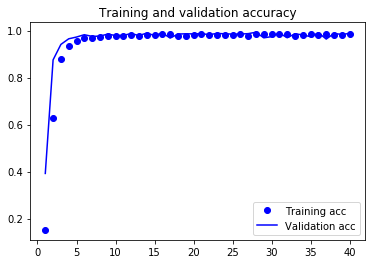

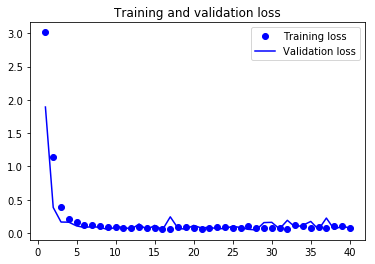

In [19]:
### Calculate and report the accuracy on the training and validation set.
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('graphs/model_training_analysis.jpg')

### Saving or Loading Model

In [17]:
#model.save('traffic_sign_classifier.h5') #save model
model = models.load_model('traffic_sign_classifier.h5') #load saved model

---

## Step 3: Test a Model on Test Dataset

We will test our model on the test dataset

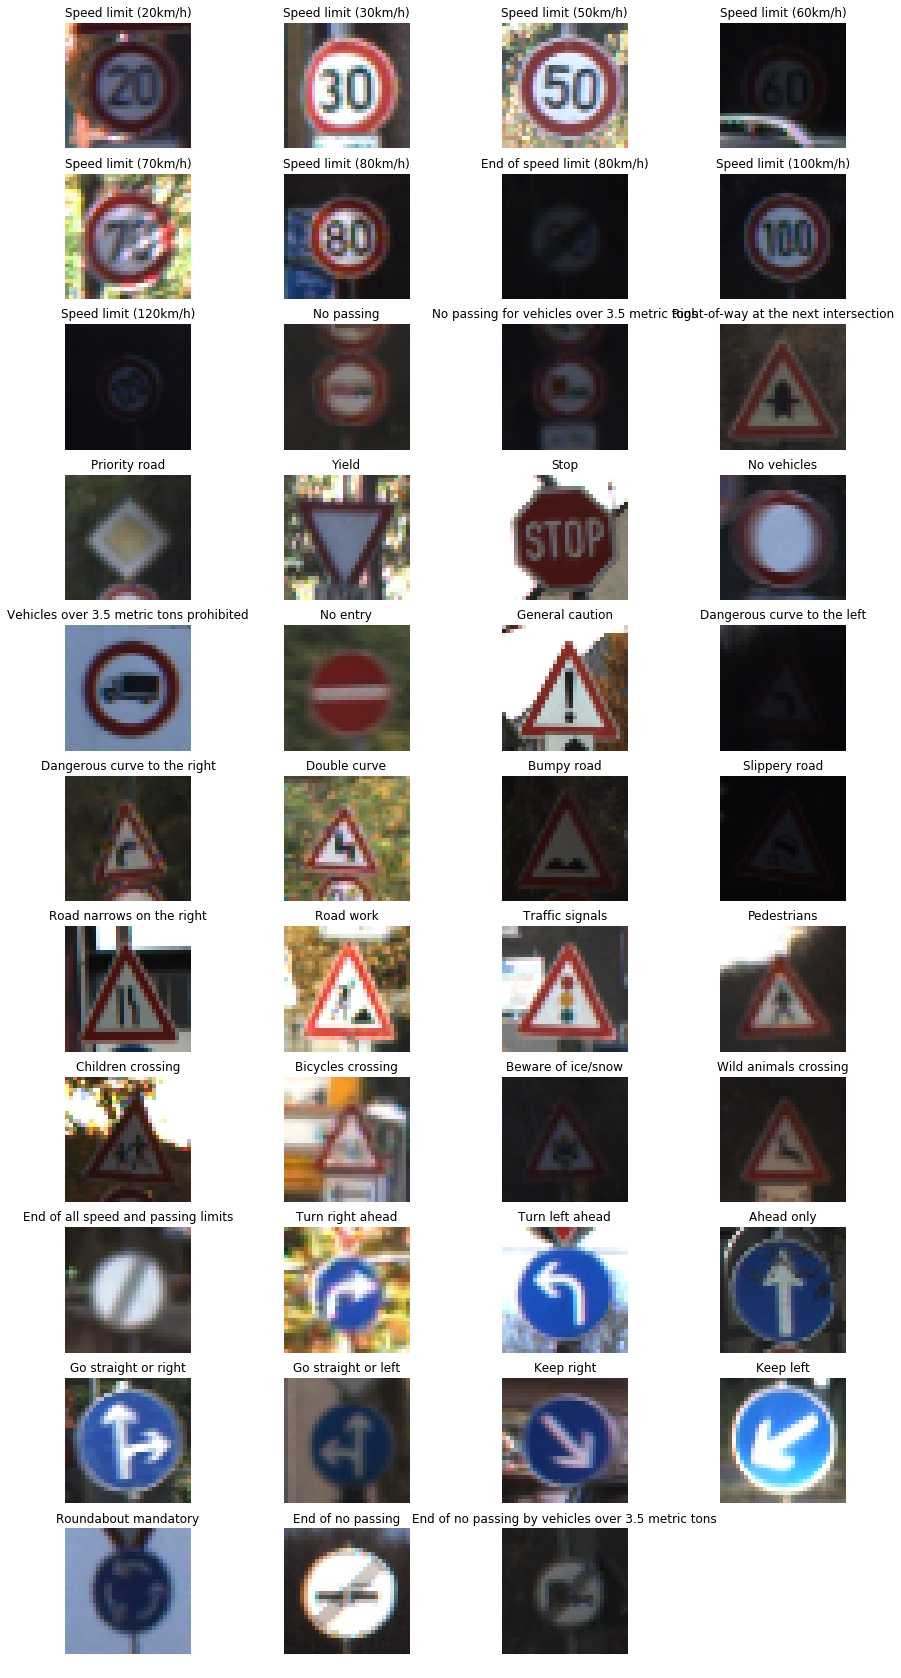

In [14]:
#View test images in the test data
plt.figure(figsize=(15, 30))
num_of_samples=[]
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = X_test[y_test == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(all_labels[i])
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.savefig('graphs/origional_test.jpg')

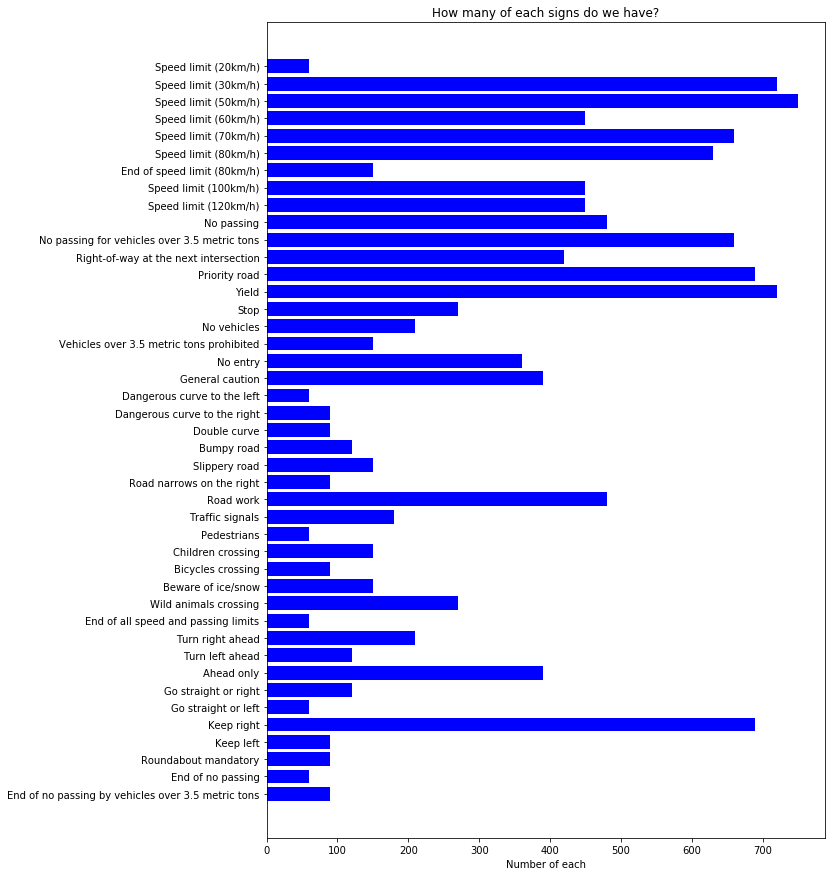

In [15]:
#Show total number of images per label in the test data
fig, ax = plt.subplots(figsize=(10, 15))
labels = np.arange(len(all_labels))
unique, numOfEach = np.unique(y_test, return_counts=True)
ax.barh(labels, numOfEach, align='center', color='blue')
ax.set_yticks(labels)
ax.set_yticklabels(all_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of each')
ax.set_title('How many of each signs do we have?')
plt.show()
plt.savefig('graphs/origional_testset_distribution.jpg')

In [18]:
#the accuracy on the test set should be calculated and reported as well.
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.9728125


## Step 4: Predict the Sign Type for Five Images of Web

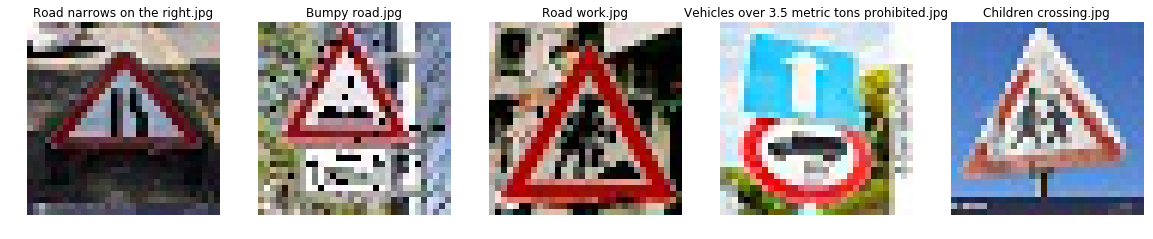

In [19]:
#import 5images
import matplotlib.pyplot as plt
images = glob.glob('five_test_images/*.jpg')
plt.figure(figsize=(20, 20))
for i, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i+1)
    plt.imshow(originalImage) #draw the first image of each class
    plt.title(images[i].split('/')[-1])
    plt.axis('off')
plt.savefig('graphs/five_input.jpg')

### Analyze Performance

In [20]:
output=[]
for img_name, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY).reshape(1,32,32,1)
    index=model.predict(originalImage)
    output.append(index)
i=1
for item in output:
    print("predictions for "+str(i)+"th image is :\n"+str(item))
    i=i+1

predictions for 1th image is :
[[  3.01494506e-13   4.01138844e-11   3.98301218e-11   7.34076736e-17
    8.24642754e-08   1.20250910e-11   1.18478785e-18   6.92991238e-21
    5.91880916e-15   9.58249480e-10   1.32280134e-17   3.77173209e-10
    2.38804290e-07   7.91035501e-11   2.63605832e-10   4.30054979e-06
    2.63528427e-25   2.08017299e-14   1.81641299e-02   4.38490119e-14
    1.22229973e-17   3.61820979e-13   6.12197459e-10   6.78818221e-13
    5.72760761e-01   5.68611881e-07   3.66618246e-01   4.24508415e-02
    4.82250698e-07   1.20550382e-07   6.02853878e-12   4.16589845e-14
    4.17457624e-10   1.33264844e-23   1.75159054e-11   4.01526634e-09
    6.19420954e-21   1.37426331e-17   2.09752741e-07   2.63560654e-17
    6.75040373e-13   1.25021660e-10   9.61682881e-28]]
predictions for 2th image is :
[[  2.74424820e-04   4.35944553e-03   3.91238369e-03   1.27080164e-03
    2.19145650e-03   3.47327063e-04   4.97676781e-04   5.10881539e-04
    6.62628328e-04   1.16704948e-01   5.292

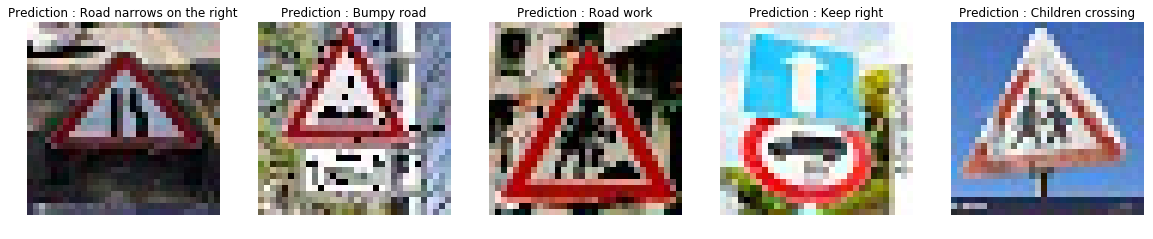

In [21]:
output_index_array=[]
for item in output:
    max_val=np.max(item)
    index=np.where(item==max_val)[1][0]
    output_index_array.append(index)
plt.figure(figsize=(20, 20))  
for i, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    plt.subplot(1,5,i+1)
    plt.imshow(originalImage) #draw the first image of each class
    plt.title("Prediction : "+ all_labels[output_index_array[i]])
    plt.axis('off')
plt.savefig('graphs/five_prediction.jpg')

In [22]:
### Calculate the accuracy for these 5 new images. 
score=0
index=0
for index in range(0,5):
    print("Input Image: "+images[index].split('/')[-1].split('.')[0]+" ,   Prediction : "+all_labels[output_index_array[index]])
    if all_labels[output_index_array[index]]==images[index].split('/')[-1].split('.')[0]:
        score=score+1
accuracy=(score/5)*100
print('\n')
print("The model predicted "+str(score)+" out of 5 signs correctly, it's "+str(accuracy)+"% accurate on these new images")

Input Image: Road narrows on the right ,   Prediction : Road narrows on the right
Input Image: Bumpy road ,   Prediction : Bumpy road
Input Image: Road work ,   Prediction : Road work
Input Image: Vehicles over 3 ,   Prediction : Keep right
Input Image: Children crossing ,   Prediction : Children crossing


The model predicted 4 out of 5 signs correctly, it's 80.0% accurate on these new images


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [23]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.
top_five=tf.nn.top_k(tf.constant(np.array(output)), k=5)
sess = tf.Session()
top_five_prediction=sess.run(top_five)
print("Top Five Predictions : "+'\n')
print(top_five_prediction)

Top Five Predictions : 

TopKV2(values=array([[[  5.72760761e-01,   3.66618246e-01,   4.24508415e-02,
           1.81641299e-02,   4.30054979e-06]],

       [[  2.01269463e-01,   1.16704948e-01,   1.02181330e-01,
           9.74366069e-02,   6.45234063e-02]],

       [[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00]],

       [[  3.95866960e-01,   1.93049967e-01,   1.02540530e-01,
           7.91767314e-02,   4.11545523e-02]],

       [[  8.43448579e-01,   6.35647699e-02,   2.81859655e-02,
           2.61977389e-02,   7.14183506e-03]]], dtype=float32), indices=array([[[24, 26, 27, 18, 15]],

       [[22,  9, 29, 38, 23]],

       [[25,  0,  1,  2,  3]],

       [[38,  9, 16,  3, 23]],

       [[28, 29,  0,  1, 30]]], dtype=int32))


[24 26 27 18 15]
[  5.72760761e-01   3.66618246e-01   4.24508415e-02   1.81641299e-02
   4.30054979e-06]
Road narrows on the right
[22  9 29 38 23]
[ 0.20126946  0.11670495  0.10218133  0.09743661  0.06452341]
Bumpy road
[25  0  1  2  3]
[ 1.  0.  0.  0.  0.]
Road work
[38  9 16  3 23]
[ 0.39586696  0.19304997  0.10254053  0.07917673  0.04115455]
Keep right
[28 29  0  1 30]
[ 0.84344858  0.06356477  0.02818597  0.02619774  0.00714184]
Children crossing


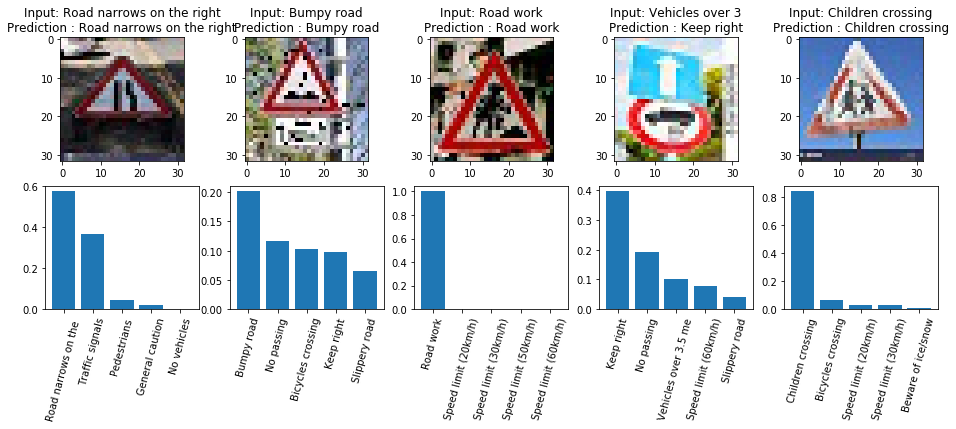

In [24]:
fig = plt.figure(figsize=(16,5))  

for index in range(0,len(images)):
    
    fig.add_subplot(2, len(images), index+1)
    originalImage= cv2.cvtColor(cv2.imread(images[index]), cv2.COLOR_BGR2RGB)
    plt.title("Input: "+images[index].split('/')[-1].split('.')[0]+"\nPrediction : "+ all_labels[output_index_array[index]])
    plt.imshow(originalImage)
              
    fig.add_subplot(2, len(images), index+1 + len(images))
    y_pos = np.arange(len(top_five_prediction[1][index][0]))
    print(top_five_prediction[1][index][0])
    print(top_five_prediction[0][index][0])
    print(all_labels[top_five_prediction[1][index][0][0]])
    plt.bar(y_pos,top_five_prediction[0][index][0])
    plt.xticks(y_pos,[all_labels[i][0:20] for i in top_five_prediction[1][index][0]], rotation=75)
plt.savefig('graphs/five_with_bar_distribution.jpg')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")